In [ ]:
import os
from pathlib import Path

from analysis.analysis_utils import load_results

MODEL_DIR = Path(os.getcwd()) / "models"

data = load_results(
    dir=MODEL_DIR, flatten=True, r2_cutoff=0.85
)

Results for the KRR Model -- Median RMSE (± 2*std):
Kf, abrahams only: -0.70 (± 0.32)
Kf, all fingerprints: -0.83 (± 0.39)
n, all fingerprints: -0.29 (± 0.15)
Results for the RF Model -- Median RMSE (± 2*std):
Kf, abrahams only: -0.77 (± 0.36)
Kf, all fingerprints: -0.86 (± 0.44)
n, all fingerprints: -0.29 (± 0.15)


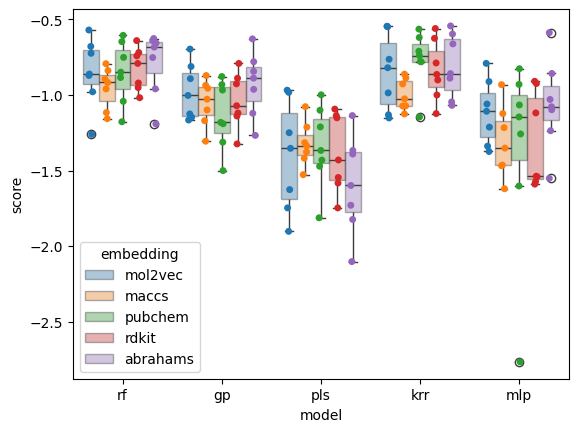

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns

all_data_kf = data[data['target'] == 'kf']
all_data_n = data[data['target'] == 'n']

kf_data_krr = all_data_kf[all_data_kf['model'] == 'krr']
n_data_krr = all_data_n[all_data_n['model'] == 'krr']

print("Results for the KRR Model -- Median RMSE (" + u"\u00B1", "2*std):")
print(
    "Kf, abrahams only:",
    format(kf_data_krr[kf_data_krr['embedding'] == 'abrahams'].explode(column='score')['score'].median(), ".2f"),
    "(" + u"\u00B1",
    format(2*kf_data_krr[kf_data_krr['embedding'] == 'abrahams'].explode(column='score')['score'].std(), ".2f") + ")"
)
print(
    "Kf, all fingerprints:",
    format(kf_data_krr.explode(column='score')['score'].median(), ".2f"),
    "(" + u"\u00B1",
    format(2*kf_data_krr.explode(column='score')['score'].std(), ".2f") + ")"
)
print(
    "n, all fingerprints:",
    format(n_data_krr.explode(column='score')['score'].median(), ".2f"),
    "(" + u"\u00B1",
    format(2*n_data_krr.explode(column='score')['score'].std(), ".2f") + ")"
)

kf_data_rf = all_data_kf[all_data_kf['model'] == 'rf']
n_data_rf = all_data_n[all_data_n['model'] == 'rf']

print("Results for the RF Model -- Median RMSE (" + u"\u00B1", "2*std):")
print(
    "Kf, abrahams only:",
    format(kf_data_rf[kf_data_rf['embedding'] == 'abrahams'].explode(column='score')['score'].median(), ".2f"),
    "(" + u"\u00B1",
    format(2*kf_data_rf[kf_data_rf['embedding'] == 'abrahams'].explode(column='score')['score'].std(), ".2f") + ")"
)
print(
    "Kf, all fingerprints:",
    format(kf_data_rf.explode(column='score')['score'].median(), ".2f"),
    "(" + u"\u00B1",
    format(2*kf_data_rf.explode(column='score')['score'].std(), ".2f") + ")"
)
print(
    "n, all fingerprints:",
    format(n_data_rf.explode(column='score')['score'].median(), ".2f"),
    "(" + u"\u00B1",
    format(2*n_data_rf.explode(column='score')['score'].std(), ".2f") + ")"
)

# boxplot for example data set (Figure 1)
example_data = all_data_kf[
    (all_data_kf['temperature'] == False) \
    & (all_data_kf['salinity'] == 'all_vals') \
    & (all_data_kf['conc_range'] == True) \
    & (all_data_kf['sorbent'] == 'name')
]
# stripplot integration
# copyright cc-by-sa johanC https://stackoverflow.com/a/67374479
sns.boxplot(
    data=example_data.explode(column='score').reset_index(),
    x='model', y='score', hue='embedding', boxprops={'alpha': 0.4},
)
sns.stripplot(
    data=example_data.explode(column='score').reset_index(),
    x='model', y='score', hue='embedding', dodge=True, legend=False
)
os.makedirs(Path(os.getcwd()) / "plots" / "evaluation", exist_ok=True)
plt.savefig(Path(os.getcwd()) / "plots" / "evaluation" / "example_rmse_plot.pdf", dpi=1500, bbox_inches="tight")
plt.show()

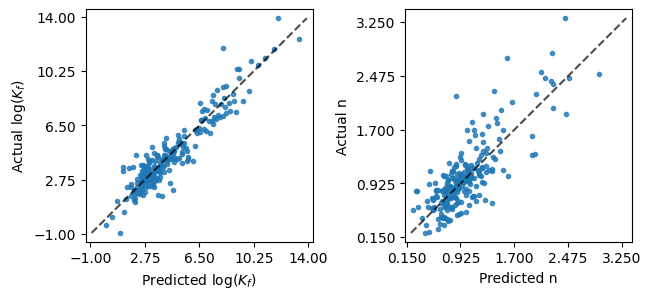

In [16]:
import numpy as np
import pickle
from matplotlib import pyplot as plt

from training.train_utils import model_path, model_name, DataSettings, ModelSettings
from sklearn.metrics import PredictionErrorDisplay

def krr_path(target):
    krr_path = model_path(
    DataSettings(
        r2_cutoff=0.85, conc_range=True, salinity='all_vals',
        temperature=False, sorbent='name'),
    path_prefix=MODEL_DIR
    )
    krr_path /= model_name(ModelSettings(model='krr', embedding='abrahams', target=target))
    return krr_path

# actual vs predicted plots for example data (Figure 2)
fig, axs = plt.subplots(ncols=2, figsize=(8*0.8, 4*0.72), layout='constrained')
for tar, ax in zip(('kf', 'n'), axs):
    with open(krr_path(tar), 'rb') as fh:
        (X, y), clf, grid, (inner_cv, outer_cv), score = pickle.load(fh)
    y_pred = np.zeros_like(y)
    for est, ind in zip(score['estimator'], score['indices']['test']):
        y_pred[ind] = est.predict(X.iloc[ind])
    PredictionErrorDisplay.from_predictions(y, y_pred, kind='actual_vs_predicted', ax=ax, scatter_kwargs={'marker':'.'})
    if tar == 'kf':
        ax.set(xlabel=f"Predicted log($K_f$)", ylabel=f"Actual log($K_f$)")
        ax.set(xticks=np.linspace(-1, 14, num=5), yticks=np.linspace(-1, 14, num=5))
    else:
        ax.set(xlabel=f"Predicted {tar}", ylabel=f"Actual {tar}")
        ax.set(xticks=np.linspace(0.15, 3.25, num=5), yticks=np.linspace(0.15, 3.25, num=5))
os.makedirs(Path(os.getcwd()) / "plots" / "evaluation", exist_ok=True)
plt.savefig(Path(os.getcwd()) / "plots" / "evaluation" / "predicted_vs_actual.pdf", dpi=1500, bbox_inches="tight")
plt.show()


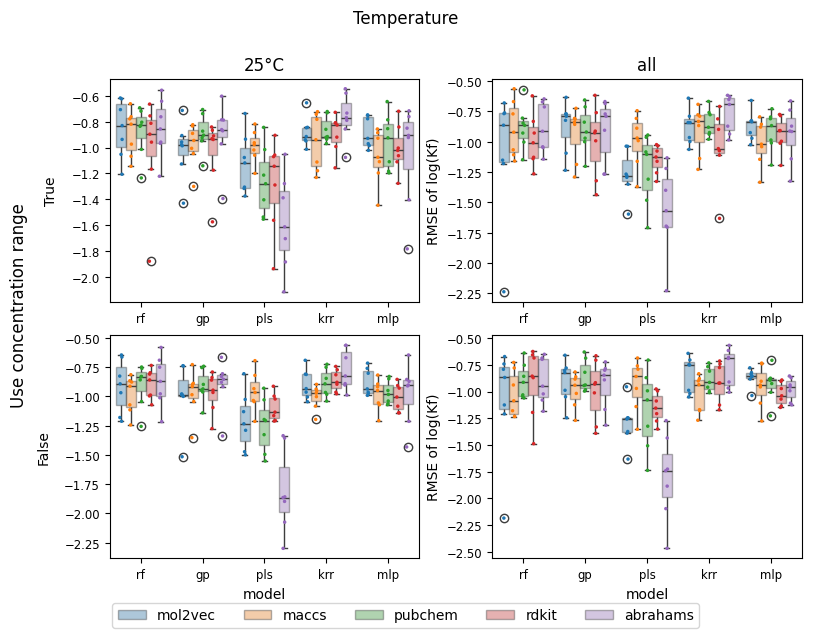

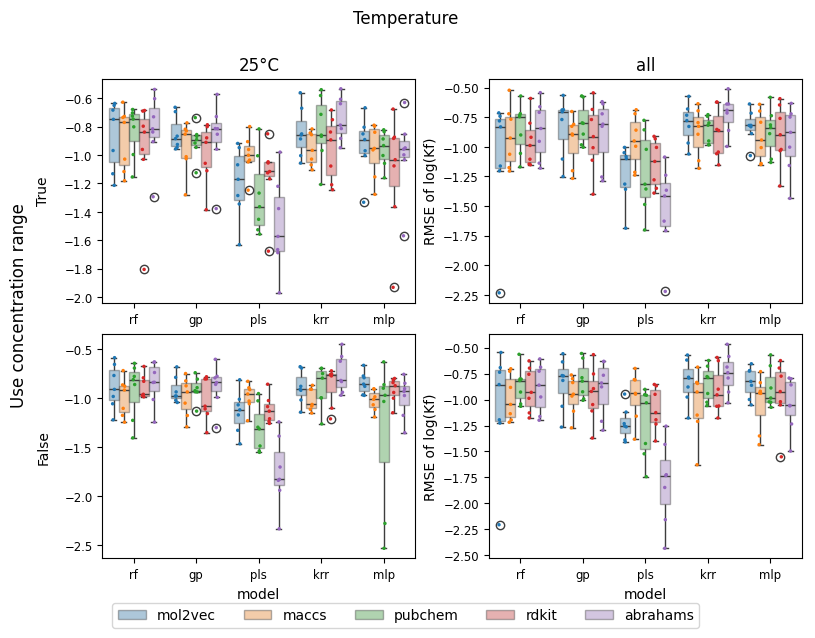

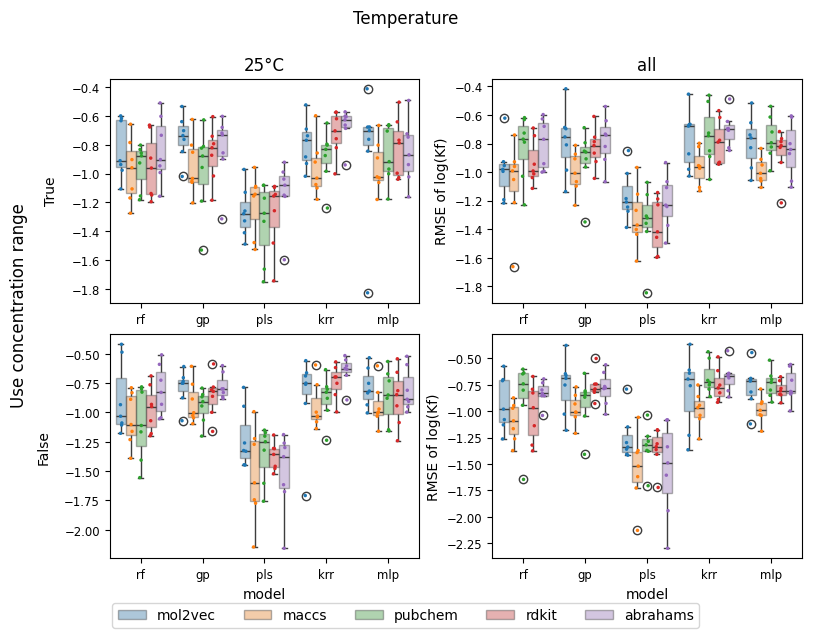

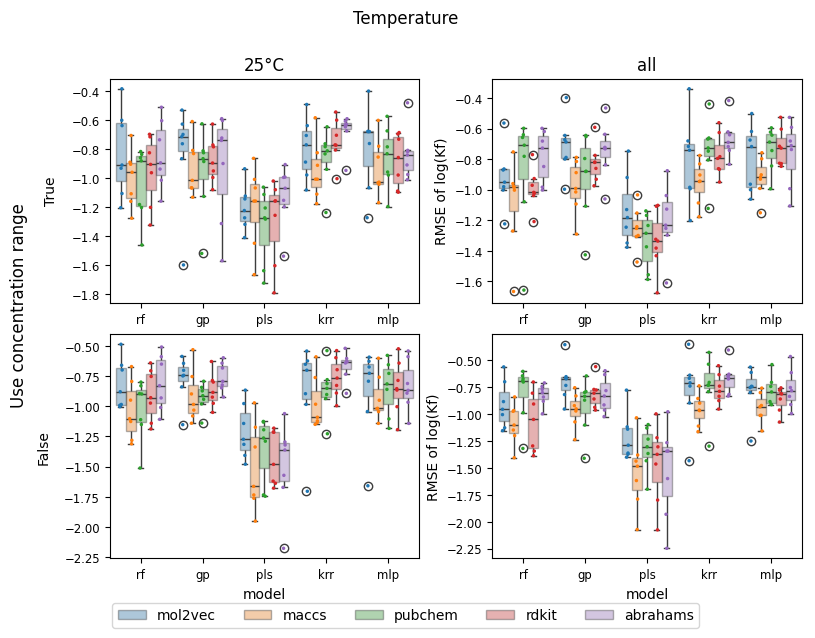

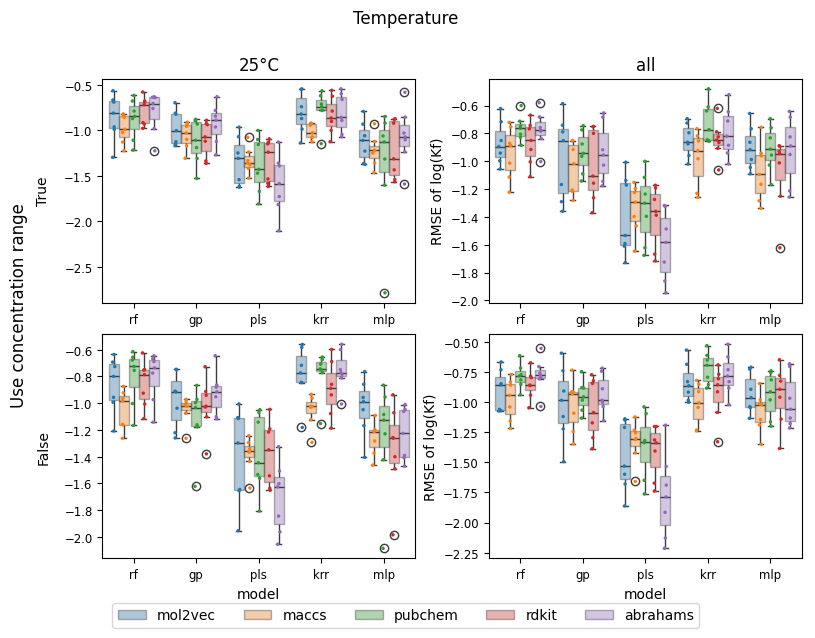

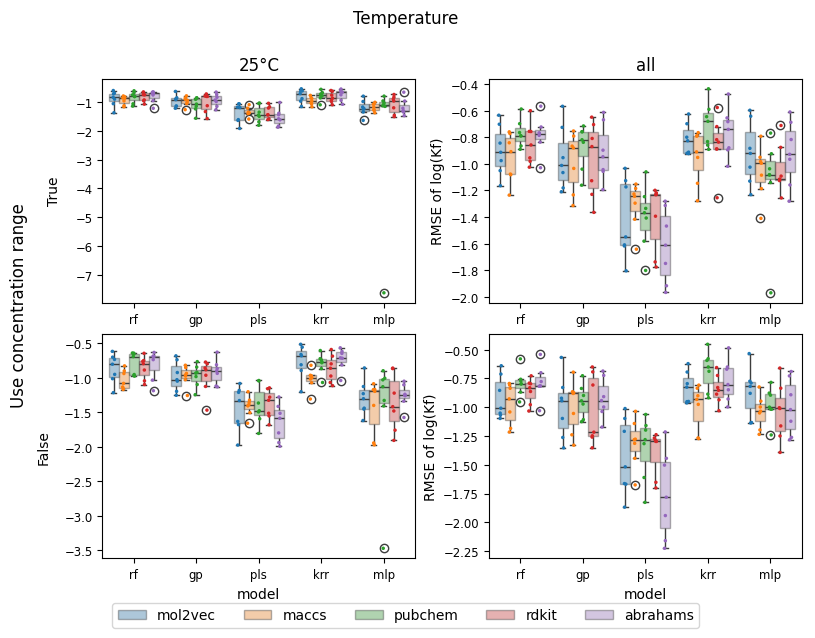

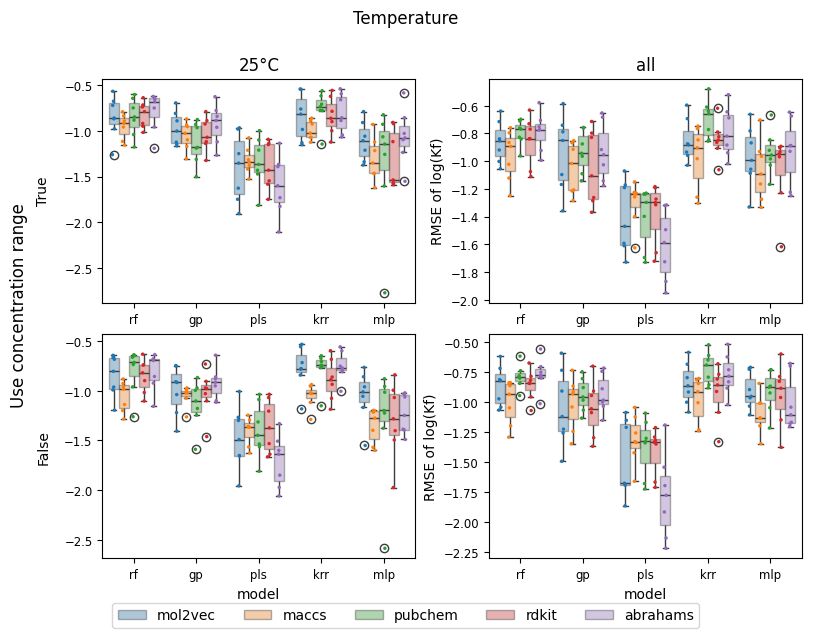

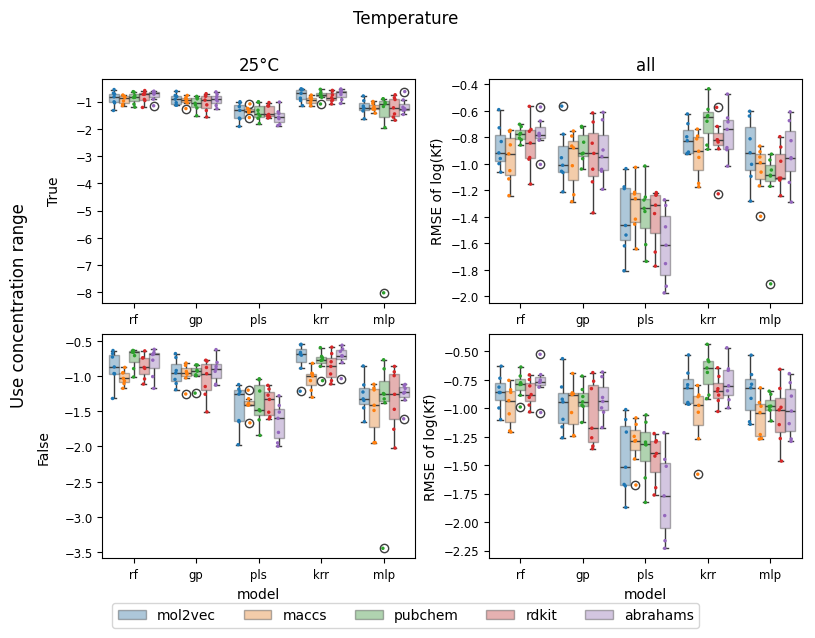

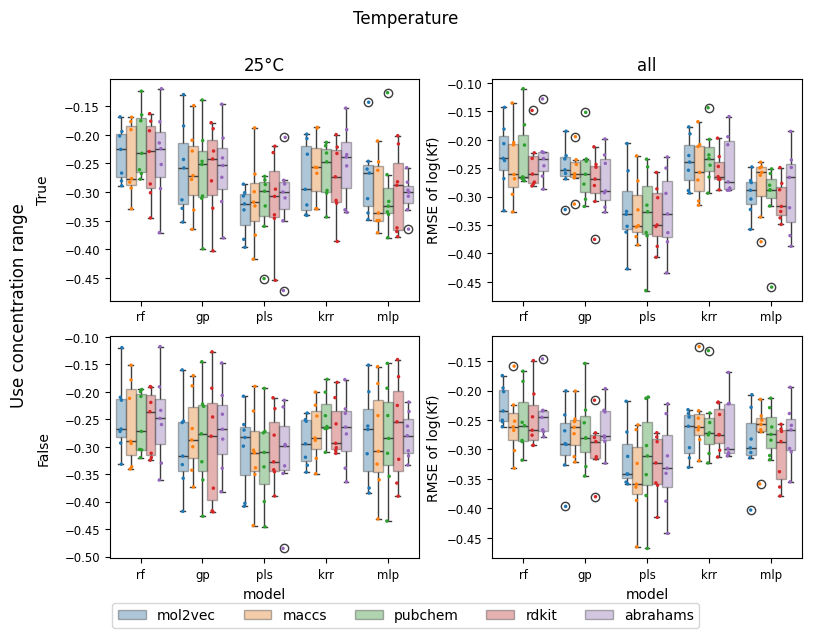

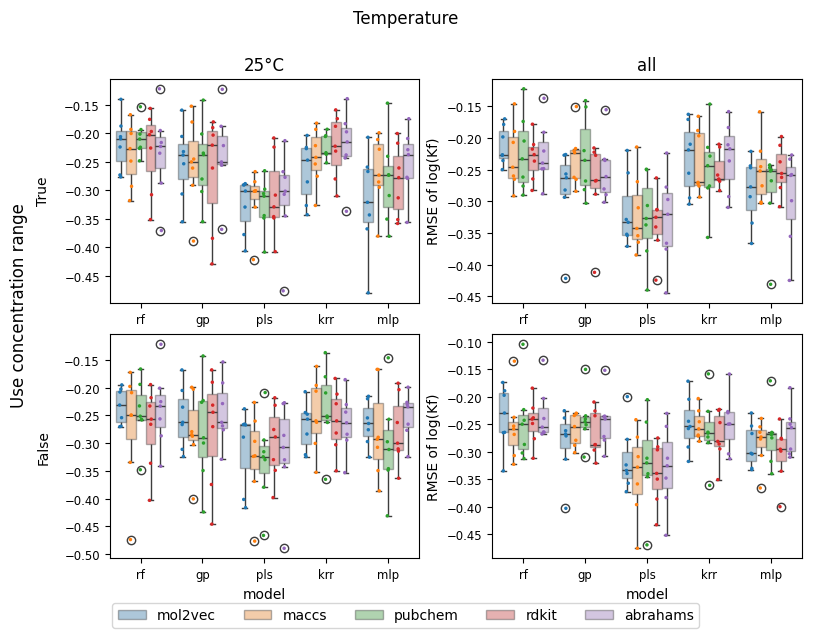

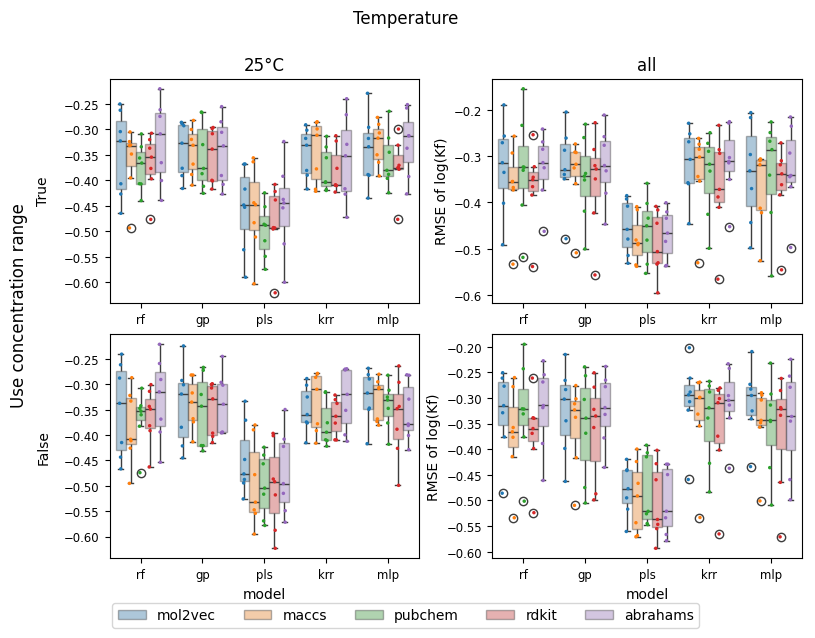

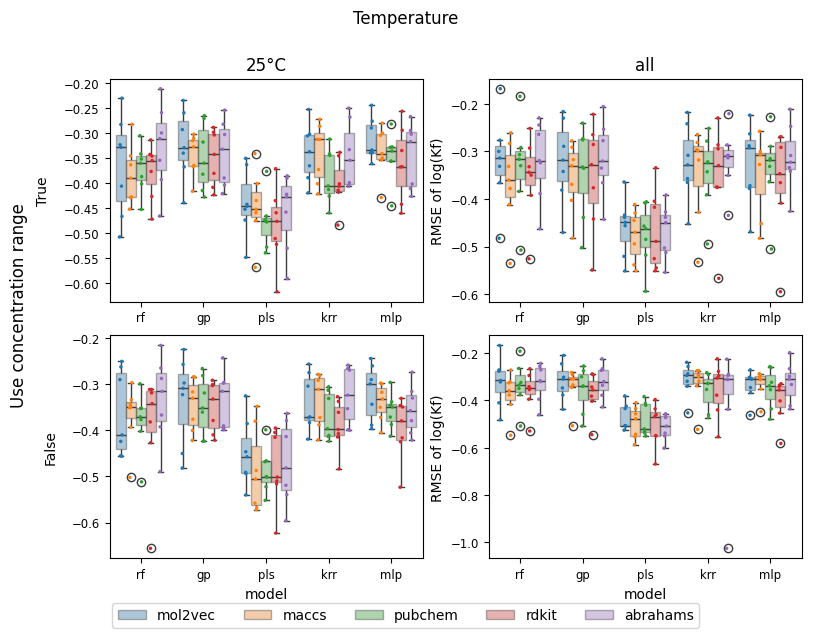

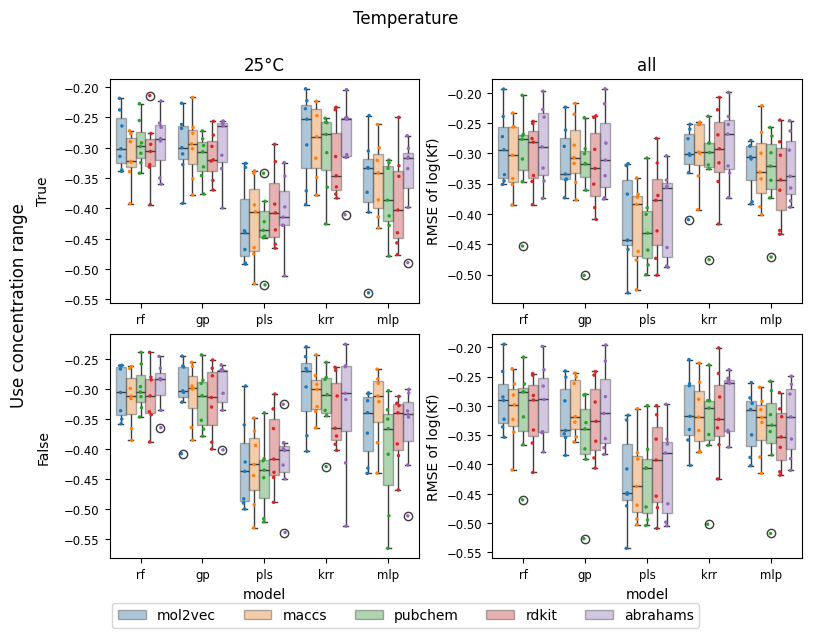

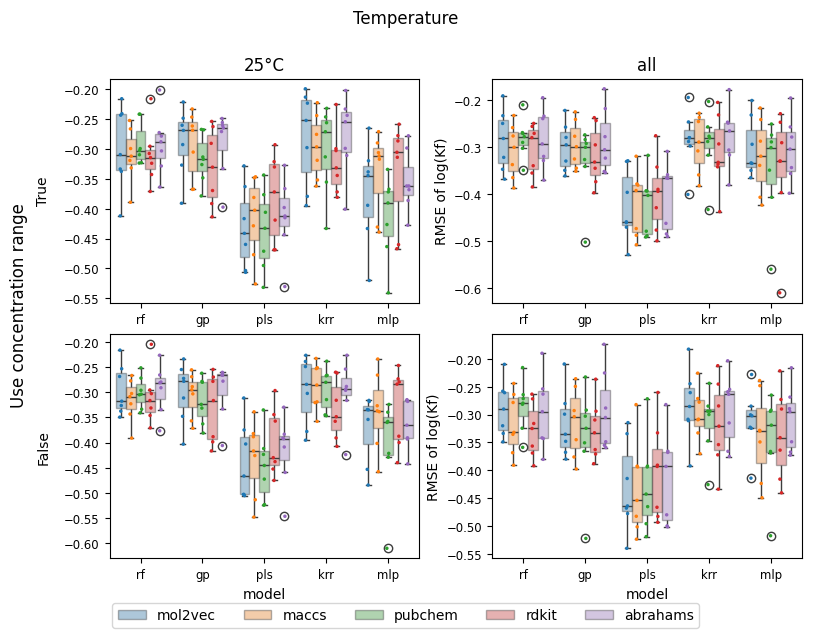

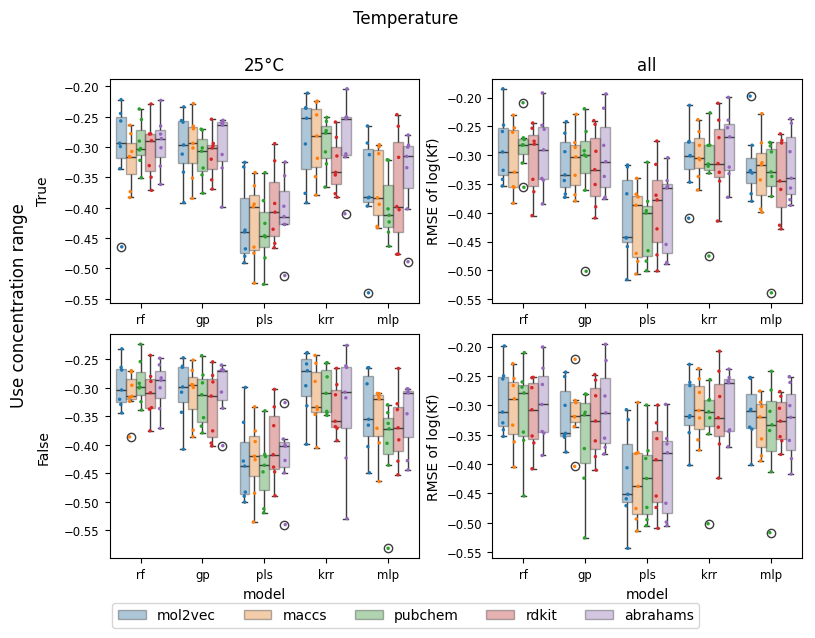

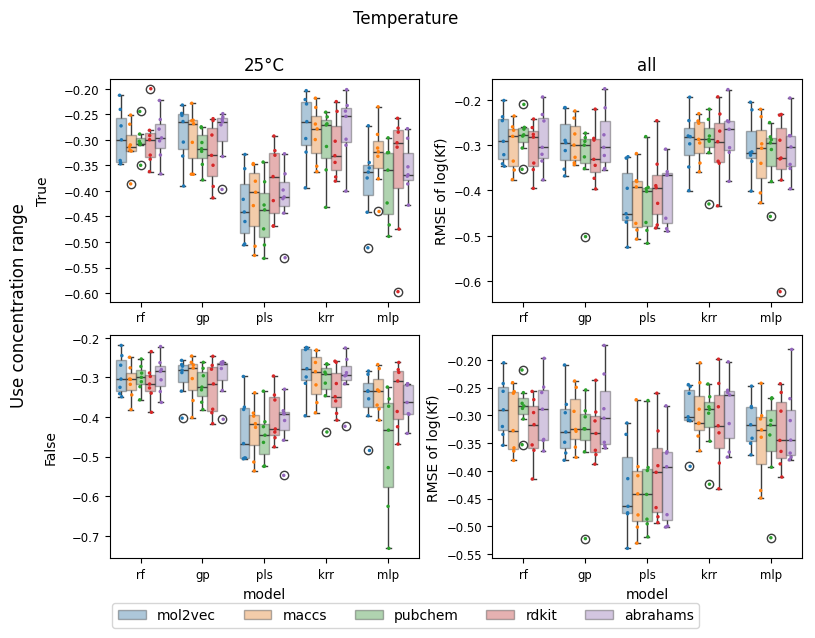

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns

def _plot_bow_facet(data, sorbent, hue='embedding'):
    x = 'model' if hue == 'embedding' else 'embedding'
    data_dict = {
        221: data[(data['conc_range'] == True) & (data['temperature'] == False) & (data['sorbent'] == sorbent)],
        222: data[(data['conc_range'] == True) & (data['temperature'] == True) & (data['sorbent'] == sorbent)],
        223: data[(data['conc_range'] == False) & (data['temperature'] == False) & (data['sorbent'] == sorbent)],
        224: data[(data['conc_range'] == False) & (data['temperature'] == True) & (data['sorbent'] == sorbent)],
    }
    # stripplot integration
    # copyright cc-by-sa johanC https://stackoverflow.com/a/67374479
    fig = plt.figure(layout='constrained', figsize=(8, 6))
    fig.subfigures(2, 1)
    needs_legend = True
    handles, labels = None, None
    for place, data in data_dict.items():
        sns.boxplot(
            data=data.dropna(axis='rows', how='any').explode(column='score').reset_index(),
            x=x, y='score', hue=hue, legend=needs_legend,
            boxprops={'alpha': 0.4}, ax=plt.subplot(place)
        )
        if needs_legend:
            handles, labels = plt.gca().get_legend_handles_labels()
            needs_legend = False
            plt.gca().get_legend().remove()
        sns.stripplot(
            data=data.dropna(axis='rows', how='any').explode(column='score').reset_index(),
            x=x, y='score', hue=hue, legend=needs_legend,
            dodge=True, s=2.5, ax=plt.subplot(place)
        )
        plt.subplot(place).tick_params(axis='both', labelsize='small')
    fig.supylabel("Use concentration range")
    plt.subplot(221).set_title("25°C")
    plt.subplot(221).set_xlabel("")
    plt.subplot(221).set_ylabel("True", labelpad=10)
    plt.subplot(222).set_xlabel("")
    plt.subplot(222).set_ylabel("RMSE of log(Kf)")
    plt.subplot(222).set_title("all")
    plt.subplot(223).set_ylabel("False", labelpad=10)
    plt.subplot(224).set_ylabel("RMSE of log(Kf)")
    fig.suptitle("Temperature\n ")
    fig.legend(
        handles, labels, loc='outside lower center', bbox_to_anchor=(0.5, -0.05),
                ncols=5
    )

# boxplots for all settings (Figures S11 - S26)
plot_path = Path(os.getcwd()) / "plots" / "evaluation"
os.makedirs(plot_path, exist_ok=True)
for param in ('kf', 'n'):
    all_data = all_data_kf if param == 'kf' else all_data_n
    for salinity in ("freshwater", "seawater", "all_water", "all_vals"):
        _plot_bow_facet(all_data[all_data['salinity'] == salinity], sorbent='name')
        plt.savefig(plot_path / f"{param}_name_{salinity}_group_embeddings.pdf", dpi=1500, bbox_inches="tight")
        plt.show()
        _plot_bow_facet(all_data[all_data['salinity'] == salinity], sorbent='comp')
        plt.savefig(plot_path / f"{param}_composition_{salinity}_group_embeddings.pdf", dpi=1500, bbox_inches="tight")
        plt.show()
